# Intercomparison

**Author:** Ivan Zvonkov, Hannah Kerner

**Last updated:** February 11, 2024

**Description:** Runs intercomparison for Zambia 2019

## 1. Setup

In [1]:
# !earthengine authenticate

In [2]:
import ee
import geemap
import sys
import pandas as pd
import geopandas as gpd

ee.Initialize()

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL, get_ensemble_area
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

## 2. Read in evaluation set

In [3]:
country = "Zambia"
country_code = TEST_CODE[country]
dataset_path = "../" + TEST_COUNTRIES[country]

In [27]:
df = gpd.read_file('zambia2019-reference-points.shp')
df['crop_label'].value_counts()

0.0    469
1.0     20
Name: crop_label, dtype: int64

In [14]:
df[CLASS_COL] = (df["crop_label"] > 0.5).astype(int)
df[COUNTRY_COL] = country

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

/Users/hkerner/anaconda3/envs/landcover-mapping/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [15]:
gdf[CLASS_COL].value_counts()

0    469
1     20
Name: binary, dtype: int64

## 3. Run intercomparison

In [16]:
TARGETS = {k:v for k,v in TARGETS.items() if k != "harvest-dev"}

In [17]:
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")
    gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

[Zambia] sampling copernicus...
[Zambia] sampling worldcover-v100...
[Zambia] sampling worldcover-v200...
[Zambia] sampling worldcereal-v100...
[Zambia] sampling glad...
[Zambia] sampling asap...
[Zambia] sampling dynamicworld...
[Zambia] sampling gfsad-gcep...
[Zambia] sampling gfsad-lgrip...
[Zambia] sampling digital-earth-africa...
[Zambia] sampling esa-cci-africa...
[Zambia] sampling globcover-v23...
[Zambia] sampling globcover-v22...
[Zambia] sampling esri-lulc...
[Zambia] sampling nabil-etal-2021...


In [8]:
a_j = {}
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] calculating pixel area for " + cropmap.title + "...")
    a_j[cropmap.title] = cropmap.compute_map_area(country, tile_grid=[2,2]).copy()

[Zambia] calculating pixel area for copernicus...
[Zambia] calculating pixel area for worldcover-v100...
[Zambia] calculating pixel area for worldcover-v200...
[Zambia] calculating pixel area for worldcereal-v100...
[Zambia] calculating pixel area for glad...
[Zambia] calculating pixel area for asap...
[Zambia] calculating pixel area for dynamicworld...
[Zambia] calculating pixel area for gfsad-gcep...
[Zambia] calculating pixel area for gfsad-lgrip...
[Zambia] calculating pixel area for digital-earth-africa...
[Zambia] calculating pixel area for esa-cci-africa...
[Zambia] calculating pixel area for globcover-v23...
[Zambia] calculating pixel area for globcover-v22...
[Zambia] calculating pixel area for esri-lulc...
[Zambia] calculating pixel area for nabil-etal-2021...


In [20]:
comparisons = []
for cropmap in TARGETS.keys():
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap], a_j[cropmap], area_weighted=True)
    comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])

In [21]:
results

,country,crop_f1,std_crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,noncrop_recall_pa,std_noncrop_pa,crop_precision_ua,...,crop_support,noncrop_support,tn,fp,fn,tp,tn_area,fp_area,fn_area,tp_area
dataset,,,,,,,,,,,,,,,,,,,,,
copernicus,Zambia,0.58,0.24,0.94,0.01,0.80,0.08,0.95,0.01,0.45,...,20,469,451,18,5,15,0.90,0.05,0.01,0.04
worldcover-v100,Zambia,0.67,0.24,0.96,0.01,0.75,0.05,0.98,0.01,0.61,...,20,469,460,9,6,14,0.93,0.02,0.01,0.04
worldcover-v200,Zambia,0.56,0.24,0.95,0.01,0.71,0.06,0.96,0.11,0.47,...,20,469,453,16,6,14,0.92,0.03,0.01,0.03
worldcereal-v100,Zambia,0.54,0.26,0.96,0.01,0.61,0.07,0.97,0.10,0.48,...,20,469,456,13,8,12,0.93,0.03,0.02,0.03
glad,Zambia,0.73,0.27,0.97,0.01,0.79,0.08,0.98,0.01,0.68,...,20,469,462,7,5,15,0.94,0.02,0.01,0.04
asap,Zambia,0.45,0.21,0.91,0.01,0.78,0.08,0.92,0.01,0.32,...,20,469,437,32,5,15,0.88,0.08,0.01,0.04
dynamicworld,Zambia,0.63,0.23,0.97,0.01,0.54,0.04,0.99,0.01,0.77,...,20,469,466,3,10,10,0.95,0.01,0.02,0.02
gfsad-gcep,Zambia,0.60,0.23,0.94,0.01,0.85,0.07,0.94,0.01,0.46,...,20,469,450,19,4,16,0.89,0.05,0.01,0.05
gfsad-lgrip,Zambia,0.59,0.23,0.94,0.01,0.85,0.07,0.94,0.01,0.46,...,20,469,450,19,4,16,0.89,0.05,0.01,0.04


In [ ]:
# Add ensemble
ensemble_maps = ["glad", "worldcover-v100", "esri-lulc", "digital-earth-africa",
                 "dynamicworld", "esa-cci-africa", "gfsad-gcep", "nabil-etal-2021",
                 "copernicus", "globcover-v23", "asap"] # Should be odd number
print(f"Ensemble maps: {ensemble_maps}")
ensemble = gdf[ensemble_maps].mode(axis='columns')
a_j['ensemble-subset'] = get_ensemble_area(country, [TARGETS[name] for name in ensemble_maps], tile_grid=[2,2])

In [23]:
comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble, a_j['ensemble-subset'], area_weighted=True)
comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])
results

,country,crop_f1,std_crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,noncrop_recall_pa,std_noncrop_pa,crop_precision_ua,...,crop_support,noncrop_support,tn,fp,fn,tp,tn_area,fp_area,fn_area,tp_area
dataset,,,,,,,,,,,,,,,,,,,,,
copernicus,Zambia,0.58,0.24,0.94,0.01,0.80,0.08,0.95,0.01,0.45,...,20,469,451,18,5,15,0.90,0.05,0.01,0.04
worldcover-v100,Zambia,0.67,0.24,0.96,0.01,0.75,0.05,0.98,0.01,0.61,...,20,469,460,9,6,14,0.93,0.02,0.01,0.04
worldcover-v200,Zambia,0.56,0.24,0.95,0.01,0.71,0.06,0.96,0.11,0.47,...,20,469,453,16,6,14,0.92,0.03,0.01,0.03
worldcereal-v100,Zambia,0.54,0.26,0.96,0.01,0.61,0.07,0.97,0.10,0.48,...,20,469,456,13,8,12,0.93,0.03,0.02,0.03
glad,Zambia,0.73,0.27,0.97,0.01,0.79,0.08,0.98,0.01,0.68,...,20,469,462,7,5,15,0.94,0.02,0.01,0.04
asap,Zambia,0.45,0.21,0.91,0.01,0.78,0.08,0.92,0.01,0.32,...,20,469,437,32,5,15,0.88,0.08,0.01,0.04
dynamicworld,Zambia,0.63,0.23,0.97,0.01,0.54,0.04,0.99,0.01,0.77,...,20,469,466,3,10,10,0.95,0.01,0.02,0.02
gfsad-gcep,Zambia,0.60,0.23,0.94,0.01,0.85,0.07,0.94,0.01,0.46,...,20,469,450,19,4,16,0.89,0.05,0.01,0.05
gfsad-lgrip,Zambia,0.59,0.23,0.94,0.01,0.85,0.07,0.94,0.01,0.46,...,20,469,450,19,4,16,0.89,0.05,0.01,0.04


In [24]:
results.to_csv('/Users/hkerner/Documents/Publications/Crop Mask Intercomparison/map-notebook-outputs/zambia-2019-results.csv')

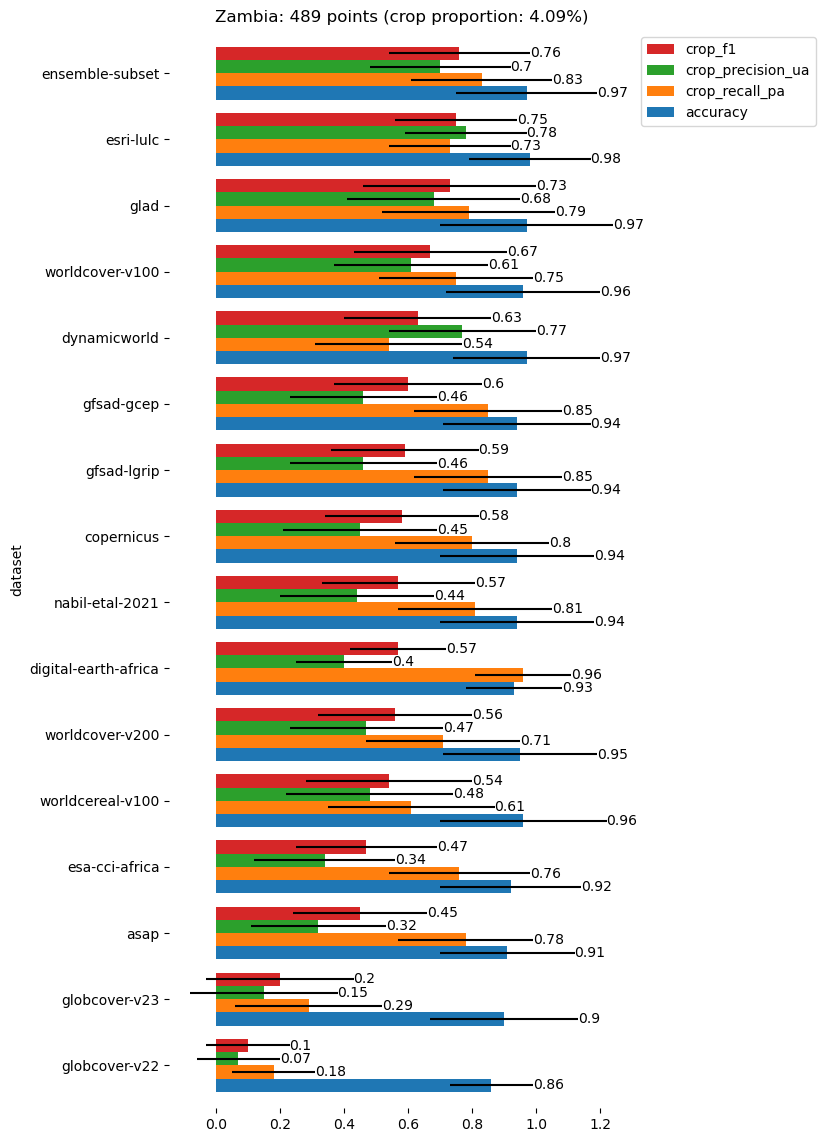

In [25]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"], 
    xerr="std_crop_f1",
    kind="barh", 
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

## 4. Visualize best available map

In [26]:
# Run this cell to view and export map
print("To view and export map copy and paste the text below the dashed line into GEE\n" + "-"*100)
best_dataset = results["crop_f1"].idxmax()
if best_dataset in TARGETS:
    print(TARGETS[best_dataset].ee_script(country))
else:
    image_var_names = [TARGETS[d].title_safe for d in ensemble_maps]
    for i, dataset in enumerate(ensemble_maps):
        print(TARGETS[dataset].ee_script(country, include_prefix=(i == 0), include_export=False))
        print("\n")
    print(f"var ensemble = ee.ImageCollection.fromImages([{', '.join(image_var_names)}]).mode()")
    print(f"Map.addLayer(ensemble, classVis, 'Cropland from ensemble');")
    print(f"""
Export.image.toCloudStorage({{
    image: ensemble,
    description: "{country}_ensemble_{'_'.join(image_var_names)}",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: "{country}_ensemble_{'_'.join(image_var_names)}",
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e10,
    skipEmptyTiles: true
}});""")

To view and export map copy and paste the text below the dashed line into GEE
----------------------------------------------------------------------------------------------------

var palettes = require('users/gena/packages:palettes');
var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}
var aoi = ee.FeatureCollection("FAO/GAUL/2015/level0")
    .filter(ee.Filter.eq('ADM0_NAME', 'Zambia'));
Map.centerObject(aoi, 7);

var glad = ee.ImageCollection("users/potapovpeter/Global_cropland_2019").filterBounds(aoi).mosaic().clip(aoi);
glad = glad.gte(0.5).rename('crop')
Map.addLayer(glad, classVis, 'Cropland from glad');


var worldcover_v100 = ee.ImageCollection("ESA/WorldCover/v100").filterBounds(aoi).mosaic().clip(aoi);
worldcover_v100 = worldcover_v100.eq(40).rename('crop')
Map.addLayer(worldcover_v100, classVis, 'Cropland from worldcover-v100');


var esri_lulc = ee.ImageCollection(
            "projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS"
        ).filter(ee